# **Final Project**, BAIT509 Winter 2023
**Business Applications of Machine Learning [100 Marks]**

**Deadline: Thursday, February 9th @ 11:59pm**

**Academic Integrity**

This is a group project. Do not share your code with other groups, or post any parts of your work online. You can only submit code that is produced by your group. If you use any online resource for developing parts of your code, you must explicitly acknowledge the source in a comment in your code. Students suspected of plagiarism on the project will be referred to the university for formal discipline according to the regulations.

**Please note that late submissions receive a mark of 0 as per course outline and RHL regulations.**

Please fill out the following:

• Full Names of all Group members: Abhijit Agrawal


• Student Numbers of all Group member: 86948742


• Group number (from Canvas): Group 24


**Two submission files are required per group:**

For submitting this project, two files must be submitted on Canvas by the project deadline:

1) The complete Jupyter file (in .ipynb format) (that completely compiles on Google colab without any errors independent of the computer used.)

2) A self-contained and complete pdf printout of the same Jupyter file with all the output printed as well as all the code, text cells, comments, and figures.

**Policy regarding the use of AI assistant tools**

If you use ChatGPT (or a similar tool) to get ideas and/or partial answers for this project or to generate any text, you must declare that you have used it, with a couple sentences describing the extent to which it was used, and you must save any generated text from this tool in case it is requested.

You will not be penalized for using such AI assistant tools, but the TA or the instructor may ask you to provide the generated text in order to help with grading decisions. In this case, your (or your group's) original contributions will be evaluated. Failure to fully declare the use of this tool will be considered "unauthorized" (See 3.b of the [Vancouver Academic Calendar](https://www.calendar.ubc.ca/vancouver/index.cfm?tree=3,54,111,1745))

## **Part 0: Loading the libraries and the data [0 Marks]**


In this project, we want to develop a statistical model for the mortality rate of lung cancer in the United States.

One of the parts overlooked in many machine learning projects is preprocessing. And a good way to learn it is by solving a lot of examples and test cases. A big part of this project is walking you through preprocessing, making informed decisions using your observations, and exploratory data analysis. Then we use supervised learning methods to construct models to predict the mortality rate of lung cancer using the features provided here.

In [49]:
# data wrangling tools
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistical learning
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


## Loading data
Load the three csv files as pandas dataframes directly from their URLs.

In [50]:
fulldf = pd.read_csv('https://saref.github.io/teaching/BAIT509/mydata.csv').drop(columns='Unnamed: 0')
data_dict = pd.read_csv('https://saref.github.io/teaching/BAIT509/descriptions.csv')
populationdf = pd.read_csv('https://saref.github.io/teaching/BAIT509/populations.csv').drop(columns='Unnamed: 0')

Data set `mydata.csv` includes most of the data. Explanations on the meaning of each of the columns are included in `descriptions.csv`. Please take your time to understand the three dataframes before proceeding.

## **Part 1: Getting started [40 Marks]**

## Data cleaning
In this project, we go through specific data cleaning steps. Please read through the instructions carefully.


### 1.1 Convert `FIPS` column to correct format [5 Marks]
Federal Information Processing Standard or [FIPS](https://en.wikipedia.org/wiki/FIPS_county_code) is a categorical variable. It is a code with five digits. The left two digits showing the state and the three right digits showing the county code. We recognize that desipite being a number, FIPS is actually a categorical variable.
First, check the format of the `FIPS` column and convert them to the five digit format with type `np.object_` as seen in the county level section, [here](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt#:~:text=county%2Dlevel%20%20%20%20%20%20place). 

*Hint*: You can use [apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html) to first convert the type and then use [`str.pad`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.pad.html) to format the values as five digit numbers.

In [51]:
#convert FIPS column to strings
fulldf['FIPS'] = fulldf['FIPS'].apply(str)
#for each value in FIPS column to be 5 characters and fill with 0 on left side if it is not 5 characters
fulldf['FIPS'] = fulldf['FIPS'].str.pad(5, side='left', fillchar='0')
#print converted column to check
fulldf['FIPS']

0       02013
1       02016
2       02020
3       02050
4       02060
        ...  
3129    56037
3130    56039
3131    56041
3132    56043
3133    56045
Name: FIPS, Length: 3134, dtype: object

### 1.2 Check for null values [5 Marks]

Just check for null values and remove columns whenever the percentage of null values is greater than 20. Please briefly justify your choices w.r.t. the columns you have removed.

**Answer**: I removed all columns that had over 20% of values missing. These columns were Med_Income_Black, Med_Income_Nat_Am, Med_Income_Asian, Med_Income_Hispanic. I also removed Med_Income_White even though it did not have more than 20% values missing. The reason for removing that column was because we removed all other columns that were breaking down the Med_Income by race. Keeping Med_Income_White would introduce a bias towards one race as that is the only race that we would end up including in the dataset so better to remove it as well.

In [52]:
# get the number of missing data points per column
missing_values_percent = ((fulldf.isnull().sum())/len(fulldf.index))*100
# look at the # of missing points in the first ten columns
missing_values_percent

###code inspired from missing values calculation by Prof. Samin Aref's in-class lab

State                   0.000000
AreaName                0.000000
All_Poverty             0.000000
M_Poverty               0.000000
F_Poverty               0.000000
FIPS                    0.000000
Med_Income              0.031908
Med_Income_White        0.063816
Med_Income_Black       38.608807
Med_Income_Nat_Am      52.967454
Med_Income_Asian       56.062540
Med_Income_Hispanic    21.729419
M_With                  0.000000
M_Without               0.000000
F_With                  0.000000
F_Without               0.000000
All_With                0.000000
All_Without             0.000000
Incidence_Rate          0.000000
Avg_Ann_Incidence       0.000000
Recent_Trend            0.000000
Mortality_Rate          0.000000
Avg_Ann_Deaths          0.000000
dtype: float64

In [53]:
#drop all columns (Med_Income_Black, Med_Income_Nat_Am, Med_Income_Asian, Med_Income_Hispanic) that are missing more than 20% values
#also drop Med_Income_White since we are dropping median income for other ethinicities. Keeping Med_Income_White will introduce a bias for the white race.
fulldf.drop(fulldf[['Med_Income_White', 'Med_Income_Black', 'Med_Income_Nat_Am', 'Med_Income_Asian', 'Med_Income_Hispanic']], axis = 1, inplace = True)

### 1.3 Check the format of columns [5 Marks]
Report the format of each column. List the columns that are in an unexpected format and state why you think that is the case.

*Hint*: You can do this by either inspecting the dataframe or by writing a code snippet that tells you what cells cannot be reformatted to the correct format. The Titatinc Jupyter file that we covered in class may also give you some useful ideas.

**Answer**: Columns Incidence_Rate, Avg_Ann_Incidence, Mortality_Rate, Avg_Ann_Deaths are in an unexpected format. Looking at the data dictionary confirms our suspicions. They are all numerical values that should be in float data type. They are probably saved as objects because of some data entry error or missing values being marked as a text/character. We can confirm these suspicions by looking at the head of those columns, where there are * or text present and this cannot be converted to float.

In [54]:
#print datatypes for the data frame
print(fulldf.dtypes)
#print head of datafram for columns I think should be float but are string to see what they look like
fulldf.iloc[:,-5:].head()
#there are some * values in the columns that means we will need to impute values before being able to convert them into float type

State                 object
AreaName              object
All_Poverty            int64
M_Poverty              int64
F_Poverty              int64
FIPS                  object
Med_Income           float64
M_With                 int64
M_Without              int64
F_With                 int64
F_Without              int64
All_With               int64
All_Without            int64
Incidence_Rate        object
Avg_Ann_Incidence     object
Recent_Trend          object
Mortality_Rate        object
Avg_Ann_Deaths        object
dtype: object


,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths
0,*,3 or fewer,*,*,*
1,*,3 or fewer,*,*,*
2,61.5,131,stable,47.3,96
3,62.7,6,stable,58.3,5
4,*,3 or fewer,*,*,*


### 1.4 Merge the population data to the main dataframe [5 Marks]
You already know about FIPS. You can use the state and county columns in this dataset to construct a FIPS column in the population dataframe in the same format as the main dataframe. Then merge the population data to the main dataframe. It is up to you to decide the type of merge and whether it is done properly.

In [55]:
#print the head of populationdf to check what it looks like
populationdf.head()

,POPESTIMATE2015,STATE,COUNTY
0,4858979,1,0
1,55347,1,1
2,203709,1,3
3,26489,1,5
4,22583,1,7


In [56]:
#check data type of columns in population df
populationdf.dtypes

POPESTIMATE2015    int64
STATE              int64
COUNTY             int64
dtype: object

In [57]:
#check if any values are missing in population df
missing_values_count = (populationdf.isnull().sum())
missing_values_count

POPESTIMATE2015    0
STATE              0
COUNTY             0
dtype: int64

In [58]:
#Format state and county columns to enable mergind population data to full df
#convert state column to string
populationdf['STATE'] = populationdf['STATE'].apply(str)
#ensure state column is 2 charaters in length and add 0 to ensure that
populationdf['STATE'] = populationdf['STATE'].str.pad(2, side='left', fillchar='0')
#convert county column to string
populationdf['COUNTY'] = populationdf['COUNTY'].apply(str)
#ensure county column is 3 charaters in length and add 0 to ensure that
populationdf['COUNTY'] = populationdf['COUNTY'].str.pad(3, side='left', fillchar='0')
#create a new column FIPS that matches the column in fulldf
#put in combination of state and county into the new column
populationdf['FIPS'] = populationdf['STATE']+populationdf['COUNTY']
#drop state and county columns as they are unnecessary and we do not want them after merging
populationdf.drop(populationdf[['STATE', 'COUNTY']], axis = 1, inplace = True)
#double check if everything worked well
populationdf.head()

,POPESTIMATE2015,FIPS
0,4858979,01000
1,55347,01001
2,203709,01003
3,26489,01005
4,22583,01007


In [59]:
#create a new merged df and left merge on the FIPS column
mergedf = fulldf.merge(populationdf, how="left", on = "FIPS")
#check datatypes in the new dataframe and ensure all relevant columns are present
mergedf.dtypes

State                 object
AreaName              object
All_Poverty            int64
M_Poverty              int64
F_Poverty              int64
FIPS                  object
Med_Income           float64
M_With                 int64
M_Without              int64
F_With                 int64
F_Without              int64
All_With               int64
All_Without            int64
Incidence_Rate        object
Avg_Ann_Incidence     object
Recent_Trend          object
Mortality_Rate        object
Avg_Ann_Deaths        object
POPESTIMATE2015        int64
dtype: object

### 1.5 Cleaning the output (response) column `Mortality_Rate` [10 Marks]
Using the file `descriptions.csv`, explain what the non-numerical values of `Mortality_Rate` mean. 

Then, it is decision making time, we have to decide whether to remove the non-numerical values from `Mortality_Rate` or to assign a specific numerical value to them. This decision is based on you inferring if the non-numerical values were caused by error in data gathering or not. 

Note that if the observations are valid and are deleted, we are adding a bias to the model.

*Hint*: To get the full mark for this part, conduct multiple relevant exploratory data analyses. Then use them to support your decision on removing or modifying the non-numerical values. Your choice results in full mark if the supporting analysis and arguments are deemed adequate and convincing.

**Answer**: Removing the data would take out important information in my opinion. Since the observations are valid, removing them would create a bias. As seen in the data dictionary, * represents fewer than 16 cases represented. To impute these values, I took the 10% quantile of the exisitng data and replaces * with that value. The reason I chose 10% quantile is because there are 10% rows with * value. If there are 10% rows with *, it means that 10% of the rows had such insignificant data that it was not recorded, hence it is the bottom 10%. Since we know these values are insignificant, median (which is typically how missing values are imputed) would be too high given the information, so 10% quantile would be the best way to represent the bottom 10% of the data.

In [60]:
#see what the mortality rate column looks like
#it contains *, the meaning of which is unknown
mergedf['Mortality_Rate'].head()

0       *
1       *
2    47.3
3    58.3
4       *
Name: Mortality_Rate, dtype: object

In [61]:
#check data dictionary to check the meaning of *
#* represents 16 or lower cases, this means that if there were too few cases to report, the data just did not include it
data_dict

,Unnamed: 0,Feature,Definition,Notes
0,0,State,NaN,NaN
1,1,AreaName,NaN,NaN
2,2,All_Poverty,Both male and female reported below poverty li...,NaN
3,3,M_Poverty,Males below poverty (Raw),NaN
4,4,F_Poverty,Females below poverty (Raw),NaN
5,5,FIPS,State + County FIPS (Raw),NaN
6,6,Med_Income,Med_Income all enthnicities (Raw),NaN
7,7,Med_Income_White,Med_Income white (Raw),NaN
8,8,Med_Income_Black,Med_Income black (Raw),NaN
9,9,Med_Income_Nat_Am,Med_Income native American (Raw),NaN


In [62]:
#check the percent of values that are *
mergedf['Mortality_Rate'].value_counts()/len(mergedf['Mortality_Rate'])*100

*       10.370134
48.3     0.606254
51.8     0.542438
56.3     0.478622
54.4     0.446713
          ...    
81.3     0.031908
31.5     0.031908
32.1     0.031908
75.8     0.031908
83.6     0.031908
Name: Mortality_Rate, Length: 618, dtype: float64

In [63]:
#temporarily relace * with np.nan so that we can convert the column to float and calculate quantiles
mergedf['Mortality_Rate'] = mergedf['Mortality_Rate'].replace('*', np.nan)
#convert column to float
mergedf['Mortality_Rate'] = mergedf['Mortality_Rate'].apply(float)

In [64]:
#Since ~10% of data is missing, we can assume that the 10% represents the lower 10% quantile of the data since those 10% rows represent rows where the data was so small that it was insignificant
#replace na.none values with the 10% quantile of the mortality rate
mergedf['Mortality_Rate'] = mergedf['Mortality_Rate'].replace(np.nan, mergedf['Mortality_Rate'].quantile(0.1))

### 1.6 Reformat the rest of the columns specified in 1.3 to numerical [5 Marks]
In each column reformat all the cells that you can. 

*Hint*: You can keep the cells that you cannot reformat until you decide if you want to use the specific column in the model. This is because you want to lose as least data as possible. So you can drop the associated rows if you want to use the column and keep them if the specific column is not used.

**Answer**: I have followed the same 10% quantile way for Incidence_Rate, Avg_Ann_Deaths, and Avg_Ann_Incidence for the same reason, there are 10% rows missing. The only difference here was that there were some _ and __ values which are truly missing values so I imputed them using the median of the available data. Further, there were some input inconsistencies like # and , in the data so those were removed as well to enable conversion into float data type.

In [65]:
#create dummy columns for Incidence_Rate, Avg_Ann_Deaths, Avg_Ann_Incidence to calculate quantiles and medians
mergedf['Incidence_Rate_dummy'] = mergedf['Incidence_Rate']
mergedf['Avg_Ann_Deaths_dummy'] = mergedf['Avg_Ann_Deaths']
mergedf['Avg_Ann_Incidence_dummy'] = mergedf['Avg_Ann_Incidence']

#clean-up the dummy columns so that they can be converted to float by relacing everything with np.nan
mergedf['Incidence_Rate_dummy'] = mergedf['Incidence_Rate_dummy'].replace('*',np.nan)
mergedf['Avg_Ann_Deaths_dummy'] = mergedf['Avg_Ann_Deaths_dummy'].replace('*',np.nan)
mergedf['Avg_Ann_Incidence_dummy'] = mergedf['Avg_Ann_Incidence_dummy'].replace('3 or fewer',np.nan)
mergedf['Incidence_Rate_dummy'] = mergedf['Incidence_Rate_dummy'].replace(['_','__'],np.nan)
mergedf['Avg_Ann_Deaths_dummy'] = mergedf['Avg_Ann_Deaths_dummy'].replace(['_','__'],np.nan)
mergedf['Avg_Ann_Incidence_dummy'] = mergedf['Avg_Ann_Incidence_dummy'].replace(['_','__'],np.nan)
#removing # and , from the data by replacing it with '' to create clean numbers that can be converted to float
mergedf['Incidence_Rate_dummy'] = mergedf['Incidence_Rate_dummy'].str.replace(' #', '')
mergedf['Avg_Ann_Deaths_dummy'] = mergedf['Avg_Ann_Deaths_dummy'].str.replace(',', '')

In [66]:
#convert all dummy columns to float
mergedf['Incidence_Rate_dummy'] = mergedf['Incidence_Rate_dummy'].apply(float)
mergedf['Avg_Ann_Deaths_dummy'] = mergedf['Avg_Ann_Deaths_dummy'].apply(float)
mergedf['Avg_Ann_Incidence_dummy'] = mergedf['Avg_Ann_Incidence_dummy'].apply(float)

In [67]:
# get the number of missing data points per column
missing_values_percent1 = ((mergedf.isnull().sum())/len(mergedf.index))*100
# look at the # of missing points in the first ten columns
missing_values_percent1

###code inspired from missing values calculation by Prof. Samin Aref's in-class lab

State                       0.000000
AreaName                    0.000000
All_Poverty                 0.000000
M_Poverty                   0.000000
F_Poverty                   0.000000
FIPS                        0.000000
Med_Income                  0.031908
M_With                      0.000000
M_Without                   0.000000
F_With                      0.000000
F_Without                   0.000000
All_With                    0.000000
All_Without                 0.000000
Incidence_Rate              0.000000
Avg_Ann_Incidence           0.000000
Recent_Trend                0.000000
Mortality_Rate              0.000000
Avg_Ann_Deaths              0.000000
POPESTIMATE2015             0.000000
Incidence_Rate_dummy       13.401404
Avg_Ann_Deaths_dummy       10.370134
Avg_Ann_Incidence_dummy    13.401404
dtype: float64

In [68]:
#Since all these columns are missing ~10% of values, we will be caluclating 10% quantile since that 10% represents the lowest 10% of the entire data as they represent data that was so small it was considered insignificant
ten_perc_inc_rate = mergedf['Incidence_Rate_dummy'].quantile(0.1).astype(str)
ten_perc_avg_death = mergedf['Avg_Ann_Deaths_dummy'].quantile(0.1).astype(str)
ten_perc_avg_inc = mergedf['Avg_Ann_Incidence_dummy'].quantile(0.1).astype(str)
#Calculating meadians for data that is completely missing represented with '_' or '__'
med_inc_rate = mergedf['Incidence_Rate_dummy'].median()
med_inc_rate = str(med_inc_rate)
med_avg_death = mergedf['Avg_Ann_Deaths_dummy'].median()
med_avg_death = str(med_avg_death)
med_avg_inc = mergedf['Avg_Ann_Incidence_dummy'].median()
med_avg_inc = str(med_avg_inc)

In [69]:
#now that we have the 10% quantile and median values for each of these 3 columns, update them in the original data
#replace * or '3 or fewer' with the 10% quantile value and replace '_', '__' with median
mergedf['Incidence_Rate'] = mergedf['Incidence_Rate'].replace('*',ten_perc_inc_rate)
mergedf['Avg_Ann_Deaths'] = mergedf['Avg_Ann_Deaths'].replace('*',ten_perc_avg_death)
mergedf['Avg_Ann_Incidence'] = mergedf['Avg_Ann_Incidence'].replace('3 or fewer',ten_perc_avg_inc)
mergedf['Incidence_Rate'] = mergedf['Incidence_Rate'].replace(['_','__'],med_inc_rate)
mergedf['Avg_Ann_Deaths'] = mergedf['Avg_Ann_Deaths'].replace(['_','__'],med_avg_death)
mergedf['Avg_Ann_Incidence'] = mergedf['Avg_Ann_Incidence'].replace(['_','__'],med_avg_inc)
#removing # and , from the data by replacing it with '' to create clean numbers that can be converted to float
mergedf['Incidence_Rate'] = mergedf['Incidence_Rate'].str.replace(' #', '')
mergedf['Avg_Ann_Deaths'] = mergedf['Avg_Ann_Deaths'].str.replace(',', '')

In [70]:
#convert columns to float
mergedf['Incidence_Rate'] = mergedf['Incidence_Rate'].apply(float)
mergedf['Avg_Ann_Deaths'] = mergedf['Avg_Ann_Deaths'].apply(float)
mergedf['Avg_Ann_Incidence'] = mergedf['Avg_Ann_Incidence'].apply(float)

In [71]:
#drop dummy columns as we do not need them anymore
mergedf.drop(mergedf[['Incidence_Rate_dummy', 'Avg_Ann_Deaths_dummy', 'Avg_Ann_Incidence_dummy']], axis = 1, inplace = True)

In [72]:
#check updated data types
mergedf.dtypes

State                 object
AreaName              object
All_Poverty            int64
M_Poverty              int64
F_Poverty              int64
FIPS                  object
Med_Income           float64
M_With                 int64
M_Without              int64
F_With                 int64
F_Without              int64
All_With               int64
All_Without            int64
Incidence_Rate       float64
Avg_Ann_Incidence    float64
Recent_Trend          object
Mortality_Rate       float64
Avg_Ann_Deaths       float64
POPESTIMATE2015        int64
dtype: object

### 1.7 Make the numerical data useful [5 Marks]
We know we have many columns of data, some of them are dependent on the populations. As a *Hint*, convert all the raw data to per 100,000 persons rates (divide by population and multiply by 100,000).

In [73]:
#check the data dictionary to see whic columns have raw data
data_dict

,Unnamed: 0,Feature,Definition,Notes
0,0,State,NaN,NaN
1,1,AreaName,NaN,NaN
2,2,All_Poverty,Both male and female reported below poverty li...,NaN
3,3,M_Poverty,Males below poverty (Raw),NaN
4,4,F_Poverty,Females below poverty (Raw),NaN
5,5,FIPS,State + County FIPS (Raw),NaN
6,6,Med_Income,Med_Income all enthnicities (Raw),NaN
7,7,Med_Income_White,Med_Income white (Raw),NaN
8,8,Med_Income_Black,Med_Income black (Raw),NaN
9,9,Med_Income_Nat_Am,Med_Income native American (Raw),NaN


In [74]:
#merged df before transformation
mergedf.head()

,State,AreaName,All_Poverty,M_Poverty,F_Poverty,FIPS,Med_Income,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths,POPESTIMATE2015
0,AK,"Aleutians East Borough, Alaska",553,334,219,02013,61518.0,876,1317,566,540,1442,1857,48.13,7.0,*,36.5,6.0,3341
1,AK,"Aleutians West Census Area, Alaska",499,273,226,02016,84306.0,2470,769,1707,564,4177,1333,48.13,7.0,*,36.5,6.0,5702
2,AK,"Anchorage Municipality, Alaska",23914,10698,13216,02020,78326.0,120747,23245,122426,21393,243173,44638,61.50,131.0,stable,47.3,96.0,298695
3,AK,"Bethel Census Area, Alaska",4364,2199,2165,02050,51012.0,6396,2708,6627,1774,13023,4482,62.70,6.0,stable,58.3,5.0,17946
4,AK,"Bristol Bay Borough, Alaska",69,33,36,02060,79750.0,419,124,349,67,768,191,48.13,7.0,*,36.5,6.0,892


In [75]:
#define i
i=0
#create a while loop to run through each row in dictionary data frame
while i < len(data_dict.index):
  #if statement to skip definitions that are Nan
  if type(data_dict['Definition'][i]) != float:
    #check if (Raw) is present in the definition column for each row
    if '(Raw)' in data_dict['Definition'][i]:
      #if (Raw) is present in definition, check if that feature name is in our dataframe, type of that feature is float, and that feature is not Med_Income
      #we ignore Med_Income as it is unreasonable to convert a $ value into per 100,000
      if data_dict['Feature'][i] in mergedf and (type(mergedf[data_dict['Feature'][i]][0]) == np.float64 or type(mergedf[data_dict['Feature'][i]][0]) == np.int64) and data_dict['Feature'][i] != 'Med_Income':
        #transoform the column if it passed all the conditions by dividing it by its population and multiplying with 100,000
        mergedf[data_dict['Feature'][i]] = mergedf[data_dict['Feature'][i]]/mergedf['POPESTIMATE2015']*100000
  #add 1 to i to create the loop
  i += 1

In [76]:
#check if the values transformed
mergedf.head()

,State,AreaName,All_Poverty,M_Poverty,F_Poverty,FIPS,Med_Income,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths,POPESTIMATE2015
0,AK,"Aleutians East Borough, Alaska",16551.930560,9997.006884,6554.923676,02013,61518.0,26219.694702,39419.335528,16941.035618,16162.825501,43160.730320,55582.161030,48.13,209.518108,*,36.5,179.586950,3341
1,AK,"Aleutians West Census Area, Alaska",8751.315328,4787.793757,3963.521571,02016,84306.0,43318.133988,13486.495966,29936.864258,9891.266222,73254.998246,23377.762189,48.13,122.763942,*,36.5,105.226236,5702
2,AK,"Anchorage Municipality, Alaska",8006.160130,3581.579872,4424.580257,02020,78326.0,40424.848089,7782.185842,40986.959942,7162.155376,81411.808032,14944.341218,61.50,43.857447,stable,47.3,32.139808,298695
3,AK,"Bethel Census Area, Alaska",24317.396634,12253.426948,12063.969687,02050,51012.0,35640.254096,15089.713585,36927.449014,9885.211189,72567.703109,24974.924774,62.70,33.433634,stable,58.3,27.861362,17946
4,AK,"Bristol Bay Borough, Alaska",7735.426009,3699.551570,4035.874439,02060,79750.0,46973.094170,13901.345291,39125.560538,7511.210762,86098.654709,21412.556054,48.13,784.753363,*,36.5,672.645740,892


## **Part 2: Exploratory analysis [15 Marks]**

### 2.1 Visualizing different features [5 Marks]
Here, show different feature and how they change with respect to each other.
*Hint*: A good function to use here is `sns.pairplot`. Remember to have the plots labeled properly so that they are self explanatory.


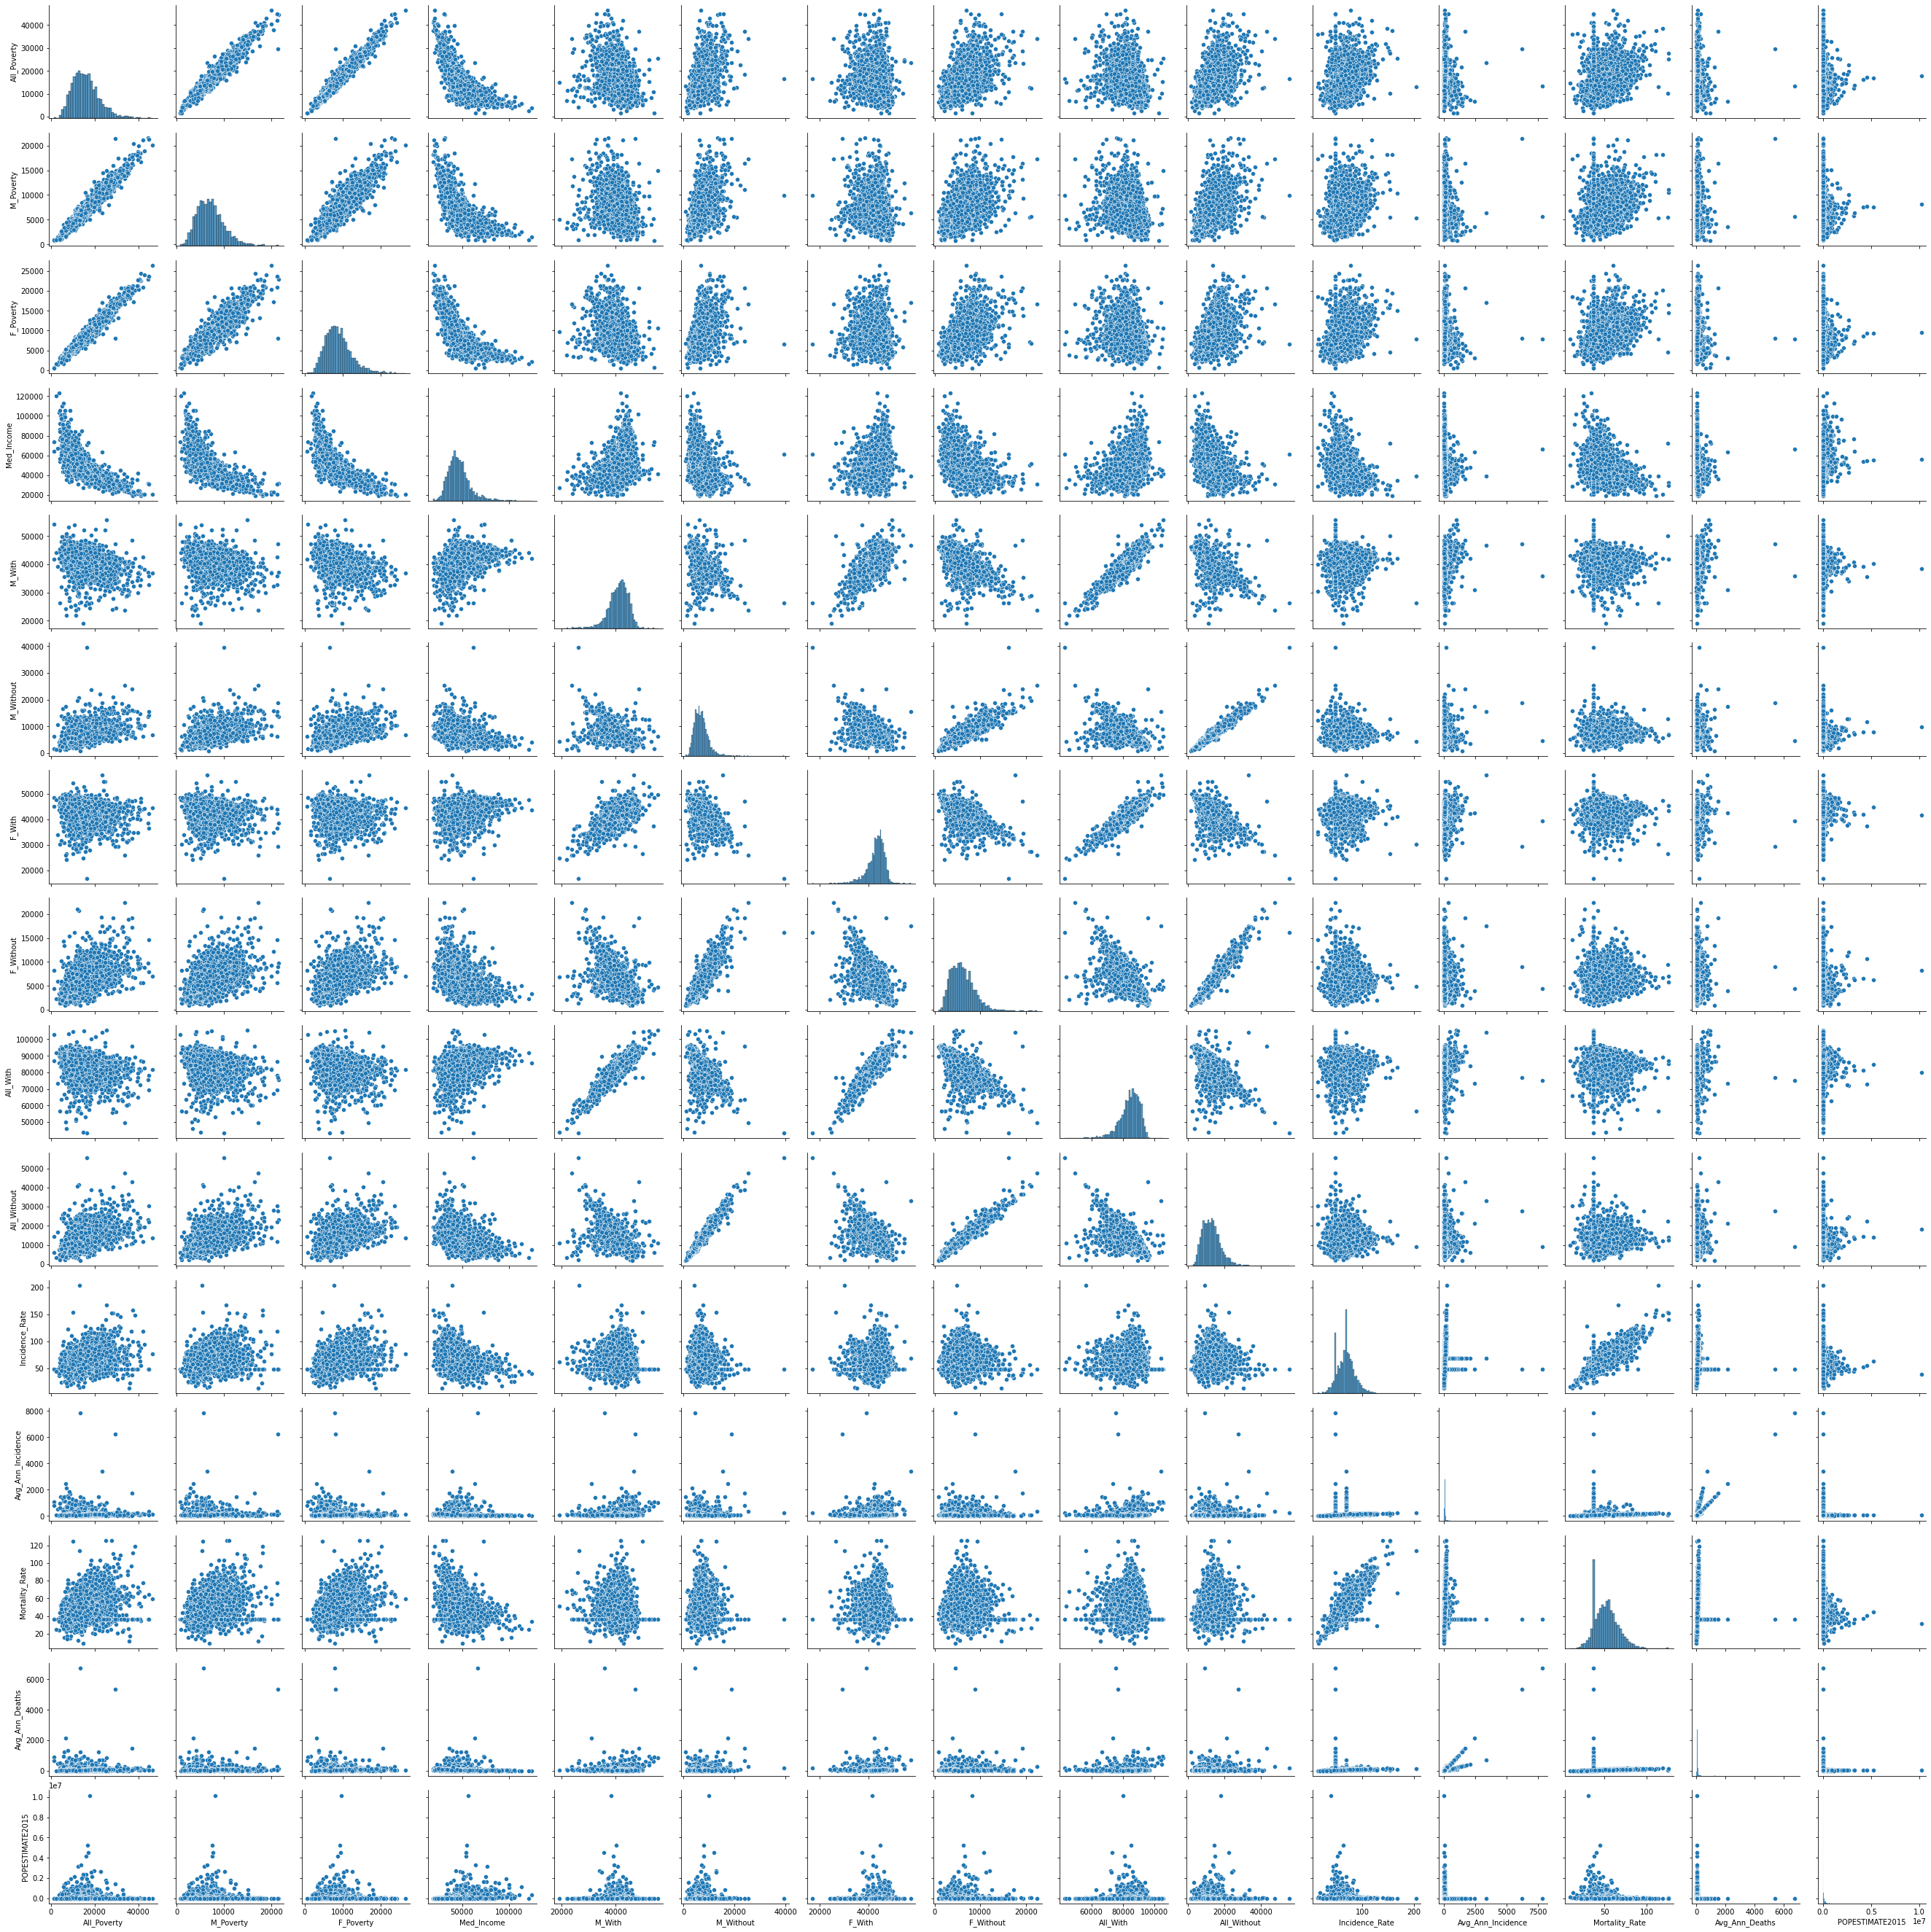

In [77]:
#create a scatter plot of all columns to check correlation
sns.pairplot(mergedf)

### 2.2 Selecting the most important features [10 Marks]
In this step, we want to remove the redundant features. 

*Hint*: This can be done by analyzing the correlation between the features and removing the highly correlated features. Remember, throughout the project, write down specific reasons for any desicion you make.

**Answer**: I removed 'M_Poverty', 'F_Poverty', because they are highly correlated to 'All_Poverty';'M_With', 'M_Without', because they are highly correlated to 'All_Without', and 'F_With', 'F_Without' because they are highly correlated to 'All_With' and this can be seen in the scatterplot above. Removing them avoids multicollinearily issues.

In [78]:
#drop columns that are correlated to each other to avoid multicolinearity 
mergedf.drop(mergedf[['M_Poverty', 'F_Poverty', 'M_With', 'M_Without', 'F_With', 'F_Without']], axis = 1, inplace = True)

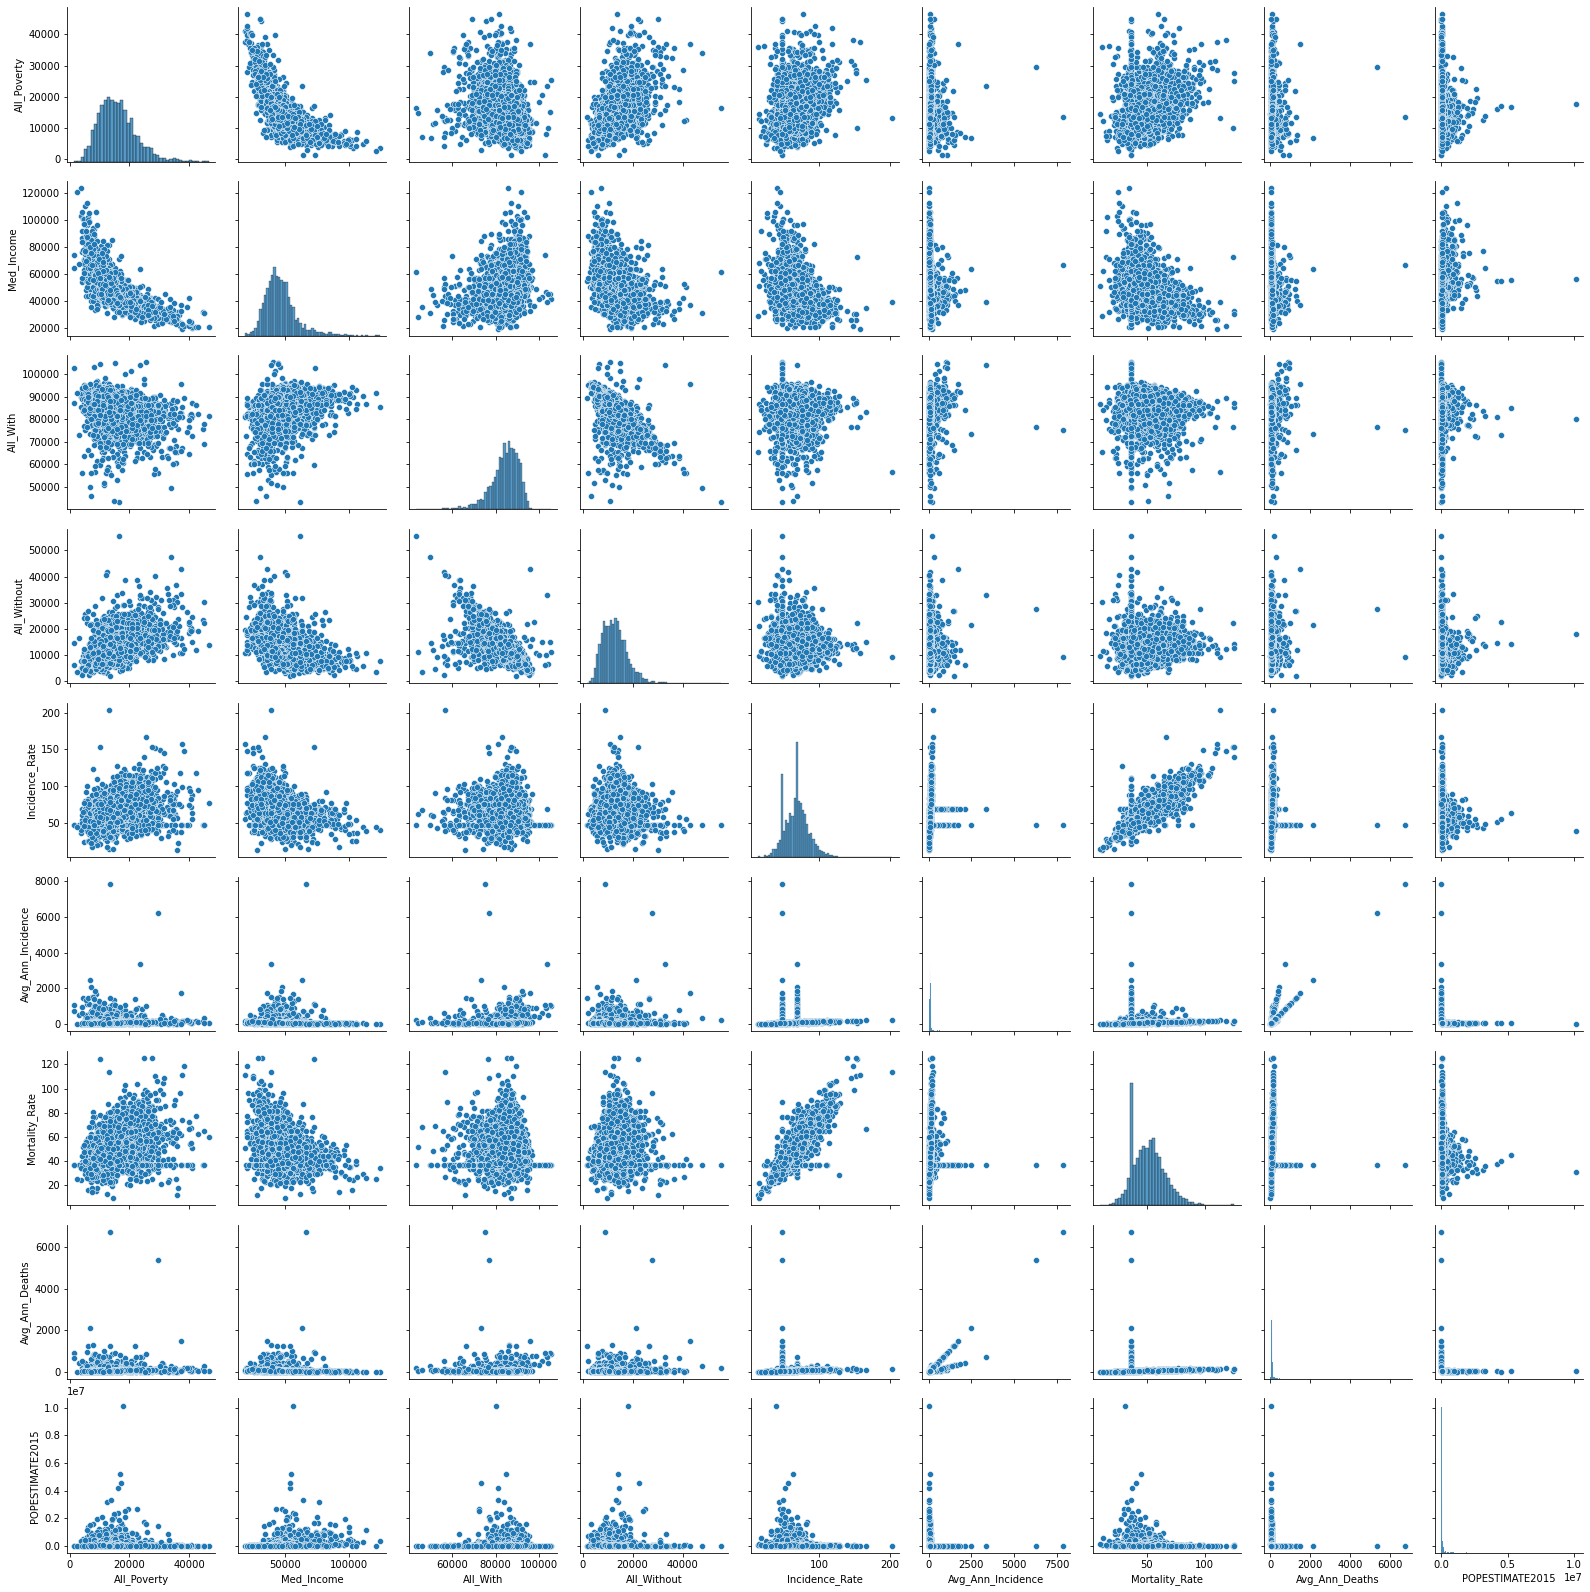

In [79]:
#recreate scatterplot to see which columns are correlated to mortality rate
sns.pairplot(mergedf)

## **Part 3: Regression Model Construction [30 Marks]**

### 3.1 Splitting the dataset [5 Marks] 

Split the dataset to three parts: train, validation, and test. You choose the ratios for the three datasets and provide a one-sentence rationale on why you went with such ratios.

*Hint*: You can use the validation set approach from ch5 lab (google colab).

**Answer**: I split the test data as 25% of the entire data to allow sufficient information in the test data to get the accuracy of our model. Within the remaining 75%, 2/3 was training and 1/3 was validation. Typically we try to keep validation and test the same length and in this case they are both 25% of the entire data. Training should be atleast double of validation/test and in this case it is 50%. Splitting like this enables us to train the models with a good amount of data, validate our models on a good size and test our final model on a similar size. 

In [80]:
#create a new dataframe with all the rows shuffled
mergedf_shuffle = mergedf.sample(frac=1).reset_index(drop=True)
#take out 25% of the data for testing
mergedf_shuffle_hold_out=mergedf_shuffle[int(0.75*len(mergedf_shuffle)):len(mergedf_shuffle)]
#rest of the 75% defines the training and validation data
mergedf_shuffle=mergedf_shuffle[0:int(0.75*len(mergedf_shuffle))]
#create a random seed
np.random.seed(1)
#2/3 of the 75% of data is training
train = np.random.choice(mergedf_shuffle.shape[0], int(2*mergedf_shuffle.shape[0]/3), replace=False)
#add a column select to define if the row is in training or validation
select = np.in1d(range(mergedf_shuffle.shape[0]), train)

###code inspired from cross-validation for regression calculation by Prof. Samin Aref's in-class lab

### 3.2 Model training [15 Marks]
Create three different models, using different features (and optionally nonlinear transformations). The purpose of these models is to predict mortality rate of lung cancer with reasonably high R2 (at least exceeding 70%) using a carefully chosen and justified set of features. Use the visualizations from section 2.1 to inform the feature selection for each model.

**Answer**: I have used forward selection, backward selection, and non-linear transformation to select 3 models.

In [81]:
#multivariate derived from forward selection where I added one additional feature to the model based on its correlation as seen in the scatter plot
#I stopped when the R^2 values does not improve drastically
lm1 = smf.ols('Mortality_Rate~Incidence_Rate+All_Poverty', data = mergedf_shuffle[select]).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Mortality_Rate   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     2009.
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:47:22   Log-Likelihood:                -5417.1
No. Observations:                1566   AIC:                         1.084e+04
Df Residuals:                    1563   BIC:                         1.086e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.9001      0.826      2.300      0.022       0.280       3.521
Incidence_Rate     0.6599      0.012     57.355      0.000       0.637       0.682
All_Poverty        0.0003   3.11e-05      8.996      0.000       0.000       0.000
==============================================================================
Omnibus:                      162.986   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1274.334
Skew:                          -0.037   Prob(JB):                    1.91e-277
Kurtosis:                       7.419   Cond. No.                     7.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [82]:
#multivariate derived from backward selection where I started with all float features and removed one feature based on its correlation as seen in the scatter plot (weak correlation removed first)
#I stopped when the R^2 values decrease drastically
lm2 = smf.ols('Mortality_Rate~Incidence_Rate+All_Poverty+Avg_Ann_Deaths+Avg_Ann_Incidence', data = mergedf_shuffle[select]).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Mortality_Rate   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     1069.
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:47:22   Log-Likelihood:                -5380.8
No. Observations:                1566   AIC:                         1.077e+04
Df Residuals:                    1561   BIC:                         1.080e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.0663      0.818      2.526      0.012       0.462       3.671
Incidence_Rate        0.6674      0.011     59.097      0.000       0.645       0.690
All_Poverty           0.0003   3.06e-05      8.368      0.000       0.000       0.000
Avg_Ann_Deaths        0.0174      0.002      7.690      0.000       0.013       0.022
Avg_Ann_Incidence    -0.0143      0.002     -8.607      0.000      -0.018      -0.011
==============================================================================
Omnibus:                      189.867   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1886.009
Skew:                           0.034   Prob(JB):                         0.00
Kurtosis:                       8.376   Cond. No.                     7.49e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [83]:
#4 degree polynomial model on the feature that is highly correlated to Mortality_Rate, Incidence_Rate
lm3 = smf.ols('Mortality_Rate~Incidence_Rate+I(Incidence_Rate ** 2)+I(Incidence_Rate **3)+I(Incidence_Rate **4)', data = mergedf_shuffle[select]).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Mortality_Rate   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     955.1
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:47:22   Log-Likelihood:                -5444.6
No. Observations:                1566   AIC:                         1.090e+04
Df Residuals:                    1561   BIC:                         1.093e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -7.6284      8.107     -0.941      0.347     -23.531       8.274
Incidence_Rate             1.6134      0.442      3.648      0.000       0.746       2.481
I(Incidence_Rate ** 2)    -0.0227      0.009     -2.646      0.008      -0.040      -0.006
I(Incidence_Rate ** 3)     0.0002   6.99e-05      3.140      0.002    8.24e-05       0.000
I(Incidence_Rate ** 4)  -7.12e-07      2e-07     -3.557      0.000    -1.1e-06   -3.19e-07
==============================================================================
Omnibus:                      138.820   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              760.494
Skew:                           0.190   Prob(JB):                    7.26e-166
Kurtosis:                       6.393   Cond. No.                     2.37e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 3.3 Model selection [10 Marks]
Using different model selection criteria and validation dataset, choose the single best perfoming model among the three models.

In [84]:
#check validation MSE for model 1
preds = lm1.predict(mergedf_shuffle)
square_error = (mergedf_shuffle['Mortality_Rate'] - preds)**2
print('--------Validation MSE for multivariate regression model using Forward Selection--------')
print('MSE:',np.mean(square_error[~select]))

###code inspired from cross validation for regression calculation by Prof. Samin Aref's in-class lab

--------Validation MSE for multivariate regression model using Forward Selection--------
MSE: 66.93162655349721


In [85]:
#check validation MSE for model 2
preds = lm2.predict(mergedf_shuffle)
square_error = (mergedf_shuffle['Mortality_Rate'] - preds)**2
print('--------Validation MSE for multivariate regression model using Backward Selection--------')
print('MSE:',square_error[~select].mean())

###code inspired from cross validation for regression calculation by Prof. Samin Aref's in-class lab

--------Validation MSE for multivariate regression model using Backward Selection--------
MSE: 63.872160039186134


In [86]:
#check validation MSE for model 3
preds = lm3.predict(mergedf_shuffle)
square_error = (mergedf_shuffle['Mortality_Rate'] - preds)**2
print('--------Validation MSE for degree 4 polynomial regression model--------')
print('MSE:',square_error[~select].mean())

###code inspired from cross validation for regression calculation by Prof. Samin Aref's in-class lab

--------Validation MSE for degree 4 polynomial regression model--------
MSE: 85.4169681256323


## **Part 4: Model diagnostics [10 marks]**
Explore model collinearity with `variance_inflation_factor`. Larger values of VIF indicate multicollinearity. Remove the problematic features and refit the model. Report how model R-squared is affected.

*Hint:* Consider VIF > 10 as an indicator of multicollinearity. If the VIF for all your features is below 10, it is a positive indication that the level of collinearity is acceptably low without any changes to the model needed in this step.

**Answer**: Model 2 drived by Backward Selection is the best model based on lowest MSE. There is no multicollinearity in the model either as seen by VIF values. This is expected because we removed features dependent on each other in step 2 by looking at the scatter plots. If there was multicollinearity, and we went back to remove itk, R^2 would maybe reduce, but not drastically.

In [87]:
#calculate vif for model 2
from patsy import dmatrices

y, X = dmatrices('Mortality_Rate~Incidence_Rate+All_Poverty+Avg_Ann_Deaths+Avg_Ann_Incidence', data = mergedf_shuffle[select], return_type='dataframe')
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

### Code for vif taken from: https://www.statology.org/how-to-calculate-vif-in-python/

,VIF,variable
0,18.489603,Intercept
1,1.102685,Incidence_Rate
2,1.103328,All_Poverty
3,5.152262,Avg_Ann_Deaths
4,5.152910,Avg_Ann_Incidence


## **Part 5: Reporting test performance [5 marks]**
Report the MSE of the final regression model using the test set.

**Answer**: Since no value of MSE can be defined as good or bad, I included the variance in the Mortality_Rate in the dataset. This shows us that the variance in the test data is higher than the MSE of the model and if MSE is less than that variance, it indicates that our model does a good job at predicting our dependent variable.

In [88]:
#create predictions for the final model which is lm2
preds = lm2.predict(mergedf_shuffle_hold_out)
#calculate MSE for final model
square_error = (mergedf_shuffle_hold_out['Mortality_Rate'] - preds)**2
print('--------Test MSE for degree 2 polynomial regression model--------')
print('MSE:',square_error.mean())
#calculate variance in mortality rate column of test data
print('--------Variance for Mortality Rate in dataset--------')
print(mergedf_shuffle_hold_out['Mortality_Rate'].var())

--------Test MSE for degree 2 polynomial regression model--------
MSE: 46.89344227414034
--------Variance for Mortality Rate in dataset--------
185.9145054180669


## **Part 6: Alternative predictive model (optional): [20 bonus points up to the maximum mark]**

Use one other supervised learning model to outperform the regression model from part 5 (in terms of MSE) on the same hold-out test set. Document, justify, and explain all your decision w.r.t. the implementation of this alternative predictive model.

This part is deliberately designed without clear instructions as bonus points for efforts of groups in completing a very common ML task without a walkthrough or instrcutions.

**Answer**: I chose decision tree model as the alternative model since it does a good job of predicting data suited to regression models and decision trees are highly interpretable. I tried bagging the decision trees, random forest, and boosting. Random makes the bagging tree more robust by randomly choosing a defined number of features (checked by cross validation) to ensure that no unnecessary bias or multicollinearity is introduced, while keeping the model highly interpretable. The MSE by these model is better than the MSE by the regression model, so we should ultimately use decision tree models for our predictions.

In [89]:
###code for part 6 inspired from decision trees (Chapter 8) for regression calculation by Prof. Samin Aref's in-class lab

#import required sklearn models
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn import tree
import matplotlib.pyplot as plt

#columns to be used as predictors for random forest model
use = ['All_Poverty', 'All_With', 'All_Without', 'Incidence_Rate', 'Avg_Ann_Incidence', 'Avg_Ann_Deaths']

#splitting our training, validation, and testing data to X and y
X_train = mergedf_shuffle[use][select]
y_train = mergedf_shuffle['Mortality_Rate'][select]
X_val = mergedf_shuffle[use][~select]
y_val = mergedf_shuffle['Mortality_Rate'][~select]
X_test = mergedf_shuffle_hold_out[use]
y_test = mergedf_shuffle_hold_out['Mortality_Rate']

In [90]:
#initiating bagged decision tree model
all_features = X_train.shape[1]
regr_bagging = RandomForestRegressor(max_features=all_features, random_state=4)
regr_bagging.fit(X_train, y_train)

#checking the validation MSE
y_pred = regr_bagging.predict(X_val)
print('--------Validation MSE for Bagged Decision Tree model--------')
print(mean_squared_error(y_val, y_pred))

--------Validation MSE for Bagged Decision Tree model--------
37.138860843112255


In [91]:
#initiating the random forest model 1 with max featues as 3
regr_rf1 = RandomForestRegressor(max_features=3, random_state=0)
regr_rf1.fit(X_train, y_train)

#checking the validation MSE
y_pred = regr_rf1.predict(X_val)
print('--------Validation MSE for Random Forest model with max features as 3--------')
print(mean_squared_error(y_val, y_pred))

--------Validation MSE for Random Forest model with max features as 3--------
39.443417510204114


In [92]:
#initiating the random forest model 1 with max featues as 4
regr_rf2 = RandomForestRegressor(max_features=4, random_state=0)
regr_rf2.fit(X_train, y_train)

#checking the validation MSE
y_pred = regr_rf2.predict(X_val)
print('--------Validation MSE for Random Forest model with max features as 4--------')
print(mean_squared_error(y_val, y_pred))

--------Validation MSE for Random Forest model with max features as 4--------
38.952997475765315


In [93]:
#initiating the random forest model 1 with max featues as 5
regr_rf3 = RandomForestRegressor(max_features=5, random_state=0)
regr_rf3.fit(X_train, y_train)

#checking the validation MSE
y_pred = regr_rf3.predict(X_val)
print('--------Validation MSE for Random Forest model with max features as 5--------')
print(mean_squared_error(y_val, y_pred))

--------Validation MSE for Random Forest model with max features as 5--------
38.481117860969405


In [94]:
#initiating the random forest model 1 with max featues as 6
regr_rf4 = RandomForestRegressor(max_features=6, random_state=0)
regr_rf4.fit(X_train, y_train)

#checking the validation MSE
y_pred = regr_rf4.predict(X_val)
print('--------Validation MSE for Random Forest model with max features as 6--------')
print(mean_squared_error(y_val, y_pred))

--------Validation MSE for Random Forest model with max features as 6--------
38.50802810204084


In [95]:
#initiating boosted decision tree model
regr_boost = GradientBoostingRegressor(n_estimators=700, learning_rate=0.03, max_depth=1, random_state=1)
regr_boost.fit(X_train, y_train)

#checking the validation MSE
y_pred = regr_boost.predict(X_val)
print('--------Validation MSE for Boosted Decision Tree model--------')
print(mean_squared_error(y_val,y_pred))

--------Validation MSE for Boosted Decision Tree model--------
48.460438060509574


**Answer**: Since the MSE starts increasing after max features = 5, we choose that as our ideal model based on cross-validation for Random Forest. But Ultimately, the MSE for bagged decision tree is the lowest so we move forward with that model.

In [96]:
#checking the test MSE
y_pred_hold_out = regr_bagging.predict(X_test)
print('--------Test MSE for Bagged Decision Tree model--------')
print(mean_squared_error(y_test, y_pred_hold_out))

--------Test MSE for Bagged Decision Tree model--------
21.863479710459185


**Answer**: Bagged Decision Tree model is better than regression model based on MSE and it does a better job at predicting the Mortality Rate.